## 코드를 써서 diabetes.csv 데이터의 Decision Tree Classifier 만들어보기


### 필수 라이브러리 로드

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 로드

In [2]:
diabetes = pd.read_csv('/content/drive/MyDrive/코드/코드/데이터 사이언스 랩/22-1학기/8강 Decision_Tree/diabetes.csv')
diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
diabetes.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

### 트리 시각화


#### 분류나무 생성

In [4]:
# sklearn 패키지로부터 import tree 
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [5]:
# 트리 시각화를 위한 모듈 import
# !pip install pydot

import pydot
from IPython.core.display import Image 

In [6]:
# X, Y 데이터셋 임의 지정
# X = diabetes.iloc[:,:(len(diabetes.columns)-1)]    # 마지막 column 제외
X = diabetes.loc[:,diabetes.columns != 'Outcome']    # 특정 coliumn명 제외 
y = diabetes['Outcome']

In [7]:
 # classification tree 구축 및 적합
clf = DecisionTreeClassifier()

In [8]:
feature_names = X.columns # DataFrame의 칼럼명을 반환하는 함수 
class_names = pd.Series.unique(y).astype('str') # 특정 시리즈가 갖고 있는 유니크한 값들 반환 / 데이터 타입 str로 변환 <- str아니면 에러 발생 

In [9]:
# 데이터셋 분할 함수 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0) # random_state: 추정기의 무작위성 제어

### Pruning 되기 전 

In [10]:
def draw_decision_tree(clf, feature_names = None, class_names = None):
    dot_data = export_graphviz(clf, out_file = None, 
                                feature_names = feature_names,
                                class_names = class_names,
                                filled = True, 
                                rounded = True,
                                special_characters = True)
    graph = pydot.graph_from_dot_data(dot_data)[0]
    image = graph.create_png()
    return Image(image)

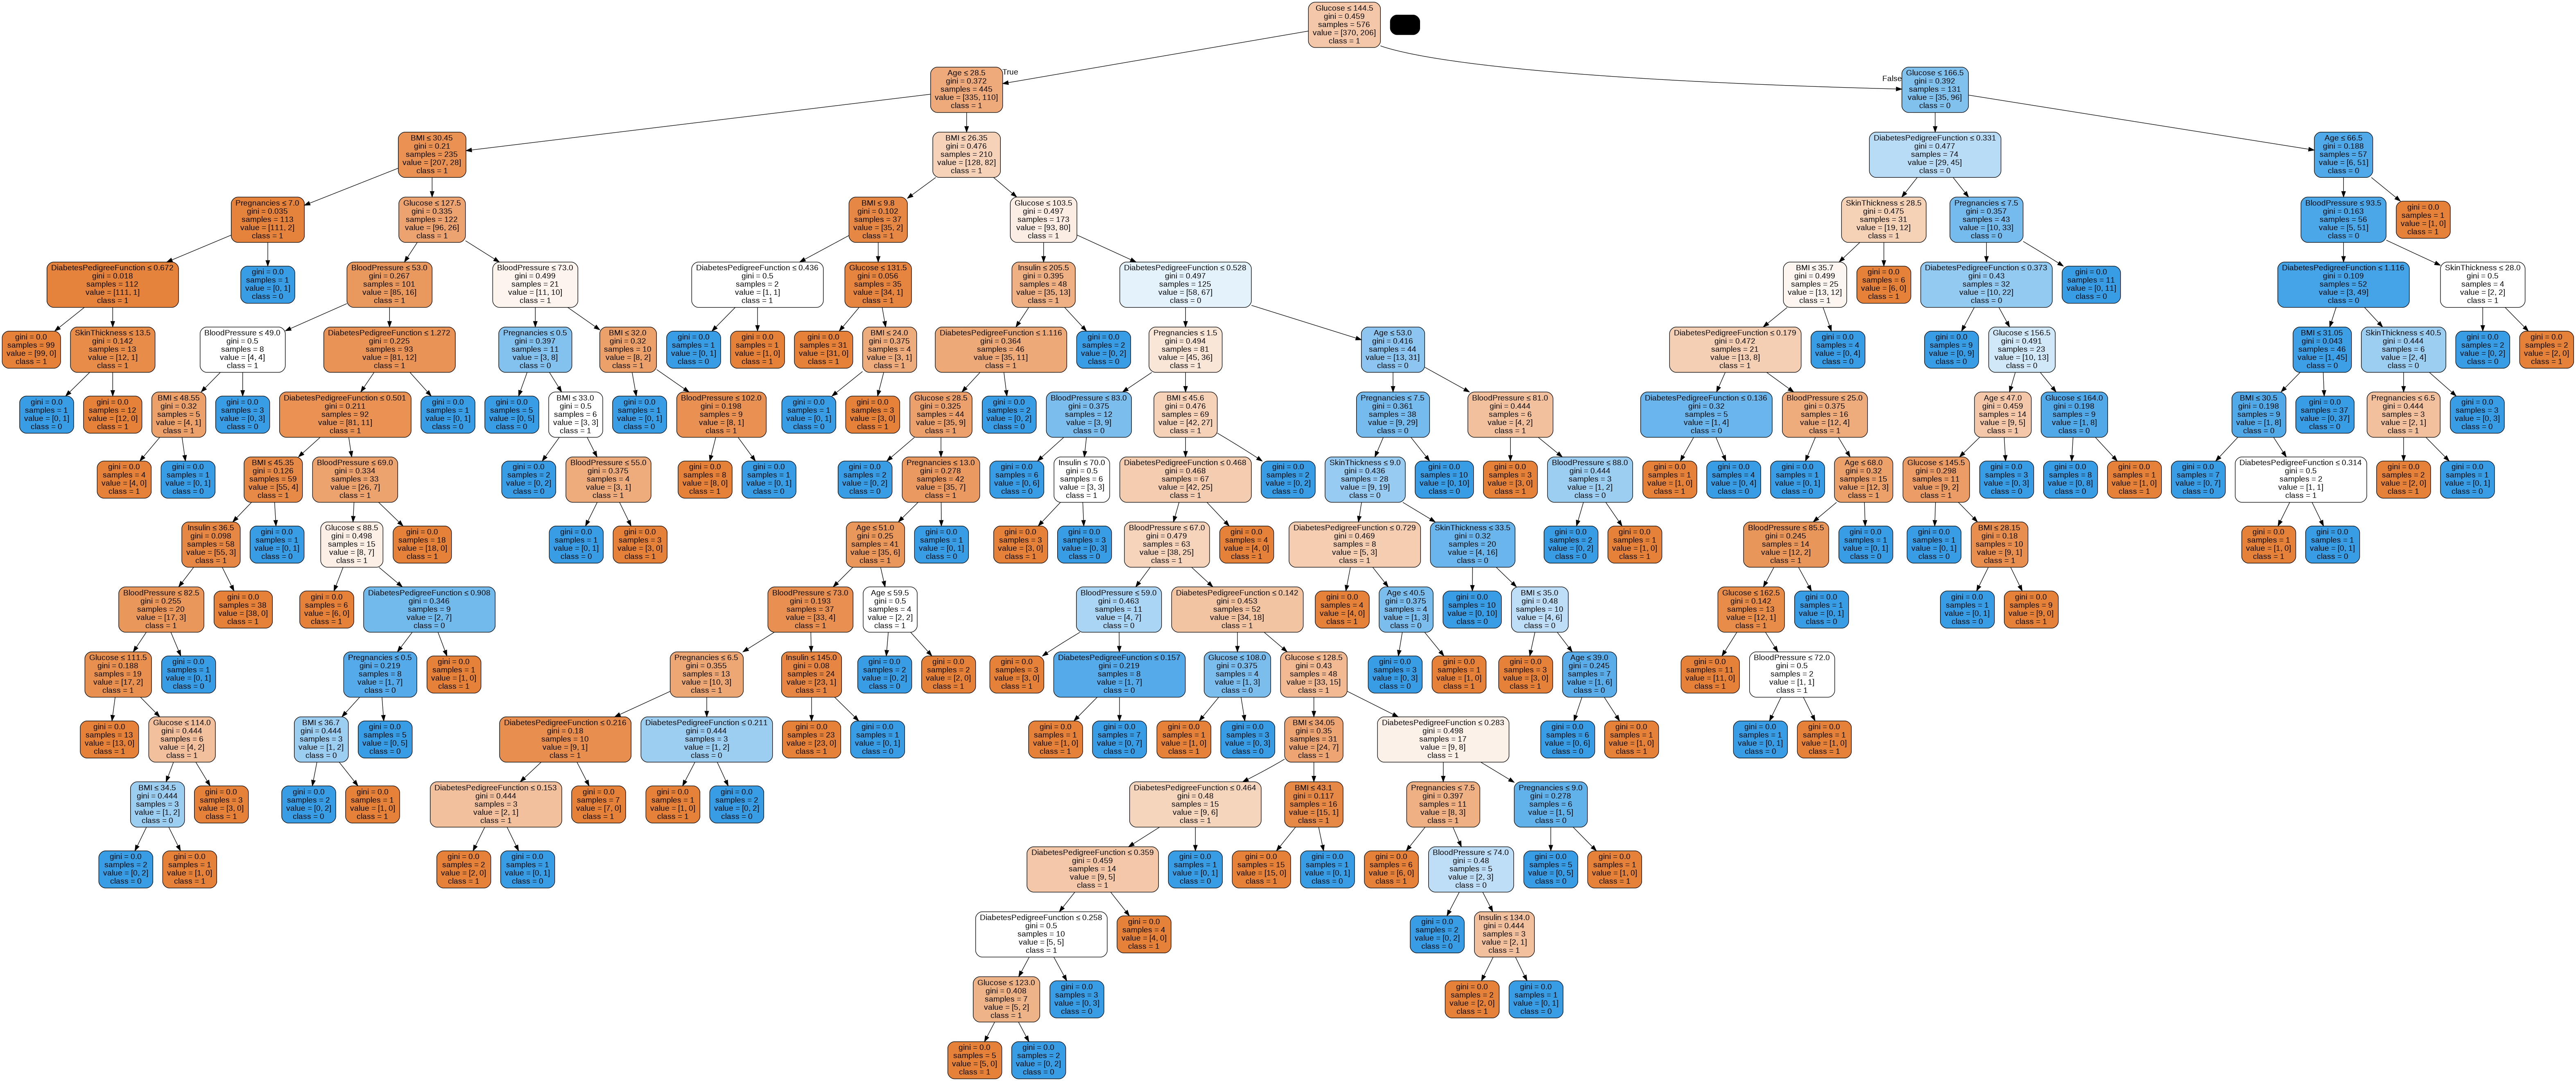

In [11]:
# Pruning 되기 전 
clf1 = DecisionTreeClassifier(random_state=0)
tree_nottuned = clf1.fit(X_train, y_train)
draw_decision_tree(tree_nottuned, feature_names, class_names)

### Accuracy 계산 : metrics.accuracy_score() 함수 사용


In [12]:
# 정확도 계산 함수
from sklearn.metrics import accuracy_score

y_pred1 =clf1.predict(X_test)
print(accuracy_score(y_pred1,y_test))

0.71875


### Pruning the Tree 를 통해 모델 성능 높이기





### Pruning: 사전 가지치기 - hyperparameter tuning (Grid Search)

- 여러 parameters 이용

    - max_depth: 트리의 최대 depth를 결정

    - min_samples_split: split하기 위해 노드가 가지고 있어야 하는 최소 샘플 개수

    - min_samples_leaf: leaf node가 가져야 하는 최소 샘플 개수

    - max_leaf_nodes: leaf node의 최대 개수

In [13]:
from sklearn.model_selection import cross_validate
import numpy as np
scoring = ['f1','precision','recall']
tree_scores = cross_validate(tree_nottuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1']))) # {:.3f}는 소수점 자리수 지정이다. <- 여기서는 소수점 3째자리까지

parameter가 tuning 되지 않았을 때의 F1 Score : 0.545


In [14]:
from sklearn.model_selection import GridSearchCV # 관심 있는 매개변수들을 대상으로 가능한 모든 조합을 시도하여 최적의 매개변수를 찾는 방법

In [15]:
# 테스트하고자 하는 파라미터 값들을 사전타입으로 정의
# max_depth 와 min_samples_split라는 parameter에 대해 범위 지정
#hyperparamters = {'max_depth': list(range(2, 10)),  'min_samples_split': list(range(2, 100)), 'max_leaf_nodes': list(range(2, 30))}

# GridSearch 진행
# GridCV = GridSearchCV(estimator=tree_nottuned, param_grid=hyperparamters, cv=5, verbose=1)

# GridCV.fit(X_train, y_train)
# GridCV.best_params_ # 가장 좋은 성능을 보였을 때의 parameter

In [16]:
tree_tuned = DecisionTreeClassifier(max_depth=4, min_samples_split=95,  random_state=0)
tree_tuned_scores = cross_validate(tree_tuned, X_train, y_train, scoring=scoring, cv=5, return_train_score = False)

print("parameter가 tuning 되지 않았을 때의 F1 Score : {:.3f}".format(np.mean(tree_scores['test_f1'])))
print("parameter가 tuning 되었을 때의 F1 Score : {:.3f}".format(np.mean(tree_tuned_scores['test_f1'])))
print("tunning으로 인한 성능 향상 + \'" + str(round(np.mean(tree_tuned_scores['test_f1']) - np.mean(tree_scores['test_f1']),3))+ "\'점")
# tuning 전의 성능보다 좋아졌음을 확인 가능

parameter가 tuning 되지 않았을 때의 F1 Score : 0.545
parameter가 tuning 되었을 때의 F1 Score : 0.625
tunning으로 인한 성능 향상 + '0.08'점


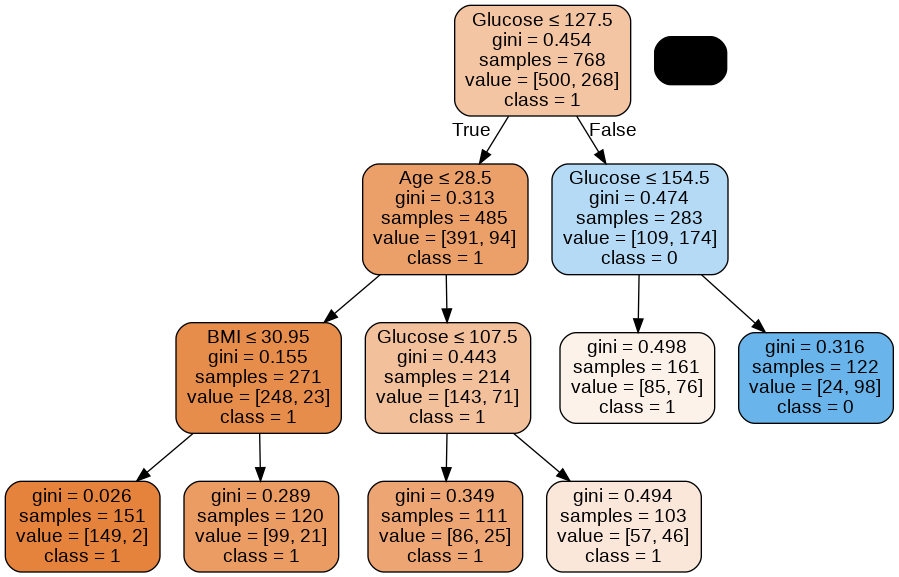

In [17]:
clf2 = DecisionTreeClassifier(min_samples_leaf = 95,max_depth=4) 
tree = clf2.fit(X, y)
draw_decision_tree(tree, feature_names, class_names)

In [18]:
y_pred2=clf2.predict(X_test)
print(accuracy_score(y_pred2,y_test))

0.7604166666666666


#### 사후 가지치기

In [19]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


In [20]:
import matplotlib.pyplot as plt

clf = DecisionTreeClassifier(random_state=0)

path = clf.cost_complexity_pruning_path(X_train, y_train)

# effective alphas, corresponding total leaf impurities 구하기
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

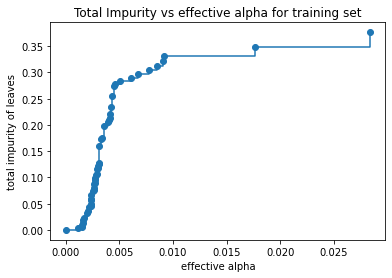

In [21]:
# effective alpha값에 따른 total impurity of leaves 그래프

fig, ax = plt.subplots()
# plt.subplots() 편의 함수는 Figure 객체를 생성하고 Figure.subplots()를 호출하여 리턴
# axes: 좌표평면을 나타내는 변수

# ccp_alphas[-1]은 노드가 하나밖에 없는 트리임.
ax.plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

# alpha 값이 커지면 트리가 작아짐 -> total impurity of leaves 커짐

In [22]:
# effective alpha 값에 대응하는 sub-trees 시각화

# clfs = []
# count = 0
# for ccp_alpha in ccp_alphas:
    # 각 effective alphas 이용해 decision tree 만들기
#    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
#    clf = clf.fit(X_train, y_train)
#    count += 1
#    print("Number of nodes in the {}th tree is: {} with ccp_alpha: {}".format(
#      count, clf.tree_.node_count, ccp_alpha))
#    display(draw_decision_tree(clf, feature_names, class_names))
#    clfs.append(clf)
#    print("====================================================================================")

# ccp_alpha = 0 일 때는 not-pruned full tree
# ccp_alpha를 0부터 시작해서 크기를 늘려감, effective alpha를 지나면 가지치기
# 마지막에는 root node만 남음
# alpha에 따라서 subtree의 크기를 조정할 수 있음을 확인

In [23]:
# alpha값에 따른 node 수의 트리의 깊이

# 노드가 하나뿐인 마지막 tree는 제외
# clfs = clfs[:-1]
# ccp_alphas = ccp_alphas[:-1]

# tree의 node 수
# node_counts = [clf.tree_.node_count for clf in clfs]

# tree의 depth
# depth = [clf.tree_.max_depth for clf in clfs]

# fig, ax = plt.subplots(2, 1)
# Number of nodes vs alpha
# ax[0].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
# ax[0].set_xlabel("alpha")
# ax[0].set_ylabel("number of nodes")
# ax[0].set_title("Number of nodes vs alpha")
# Depth vs alpha
# ax[1].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
# ax[1].set_xlabel("alpha")
# ax[1].set_ylabel("depth of tree")
# ax[1].set_title("Depth vs alpha")
# fig.tight_layout()

# alpha 값이 커지면 트리는 작아지므로, node의 수와 트리의 깊이도 작아짐

In [24]:
# testing accuracy를 높이는 최고의 ccp_alpha는?

# train_scores = [clf.score(X_train, y_train) for clf in clfs]
# test_scores = [clf.score(X_test, y_test) for clf in clfs]

# fig, ax = plt.subplots()
# ax.set_xlabel("alpha")
# ax.set_ylabel("accuracy")
# ax.set_title("Accuracy vs alpha for training and testing sets")
# ax.plot(ccp_alphas, train_scores, marker='o', label="train",
#        drawstyle="steps-post")
# ax.plot(ccp_alphas, test_scores, marker='o', label="test",
#         drawstyle="steps-post")
# ax.legend()
# plt.show()

# print("Decision tree without pruning : {0} nodes, {1:.3} accuracy".format(tree_nottuned.tree_.node_count, tree_nottuned.score(X_test, y_test)))
# print("Decision tree with the best pruning : {0} nodes, {1:.3} accuracy".format(clfs[test_scores.index(max(test_scores))].tree_.node_count, max(test_scores)))

# 가장 높은 accuracy를 보이는 ccp_alpha 값은 약 0.0046
# effective alpha = 약 0.0.0046일 때 가장 높은 성능을 가지는 sub-tree가 만들어짐

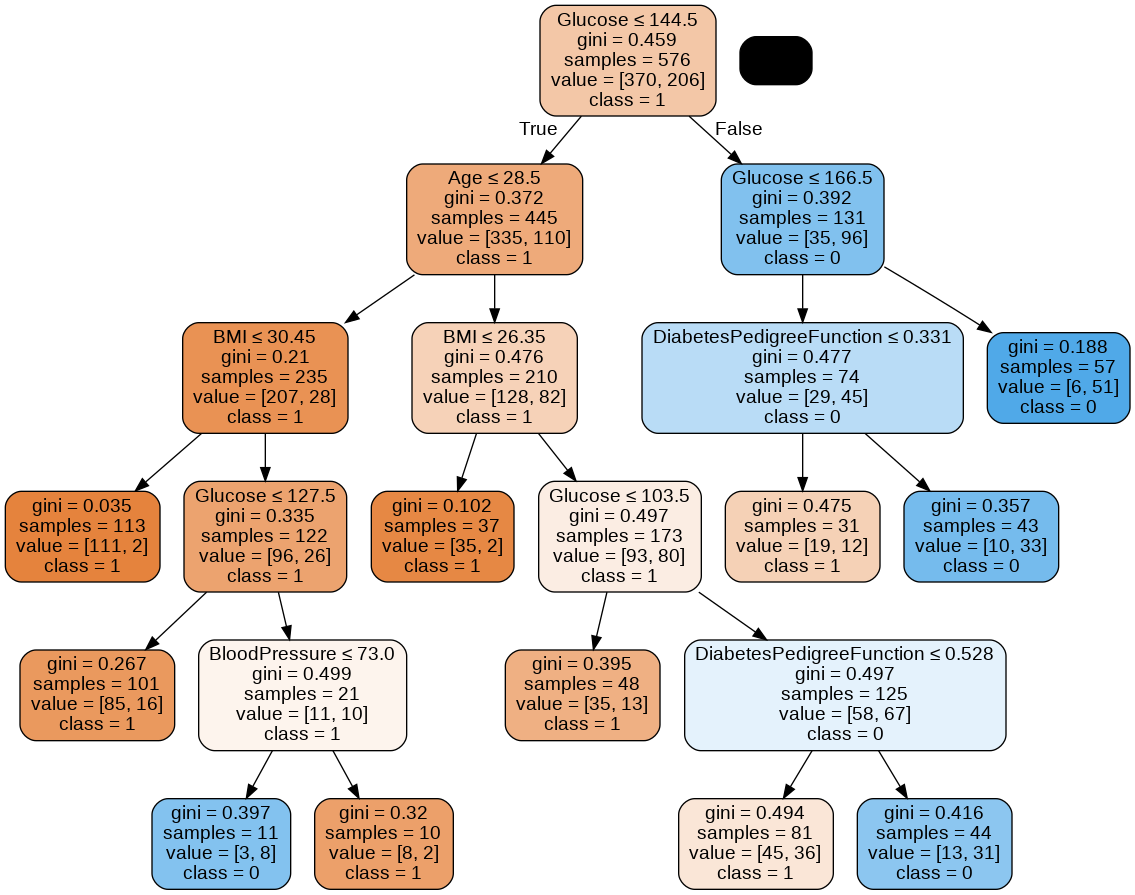

In [26]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf3 = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0046)
clf3 = clf3.fit(X_train, y_train)
draw_decision_tree(clf3, feature_names, class_names)

# sub-trees 중 가장 성능 좋음
# overfitting 방지되었다고 추정

In [27]:
y_pred3 =clf3.predict(X_test)
print(accuracy_score(y_pred3,y_test))

0.7760416666666666


#### 사전/사후 Prunning 조건 복수 사용

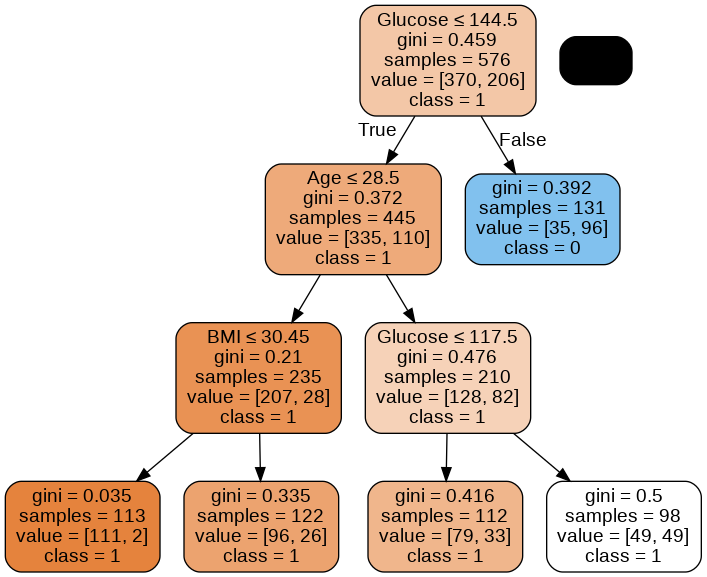

In [29]:
# testing accuracy를 높이는 최고의 ccp_alpha
clf4 = DecisionTreeClassifier(random_state=0, ccp_alpha=0.0046,min_samples_leaf = 95,max_depth=4)
clf4 = clf4.fit(X_train, y_train)
draw_decision_tree(clf4, feature_names, class_names)

In [30]:
y_pred4 =clf4.predict(X_test)
print(accuracy_score(y_pred4,y_test))

0.75


#### Accuracy 비교

In [31]:
print("Prunning전: " + str(accuracy_score(y_pred1,y_test)) + "점")
print("사전 Prunning 후: " + str(accuracy_score(y_pred2,y_test)) + "점")
print("사후 Prunning 후: " + str(accuracy_score(y_pred3,y_test)) + "점")
print("사전/사후 Prunning 후: " + str(accuracy_score(y_pred4,y_test)) + "점")

Prunning전: 0.71875점
사전 Prunning 후: 0.7604166666666666점
사후 Prunning 후: 0.7760416666666666점
사전/사후 Prunning 후: 0.75점


# 결론: CCP Alpha  기준의 사후 Prunning 조건을 적용했을 때 가장 정확도가 높다.